# Using DoppleGANger by ydata-synthetics

We are using Paqarin to replicate [this demo](https://github.com/ydataai/ydata-synthetic/blob/dev/examples/timeseries/mba_doppelganger.py).

## Initial Setup

This notebook depends on the `ydata-synthetic` library. To install it from a downloaded version, please run the following

In [24]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
from os import chdir

VERTEX: bool = False
save_after_fitting: bool = False
load_from_disk: bool = False

evaluation_iterations: int = 3 # Originally this was 10
epochs: int = 100 # Originally was 400
scorer_epochs: int =  100 # Originally was 200

WORKING_DIRECTORY:str = "C:\\PythonProjects\\paqarin"
TRAINING_DATA_FILE: str = "data\\fcc_mba.csv"

if VERTEX:
    WORKING_DIRECTORY:str = "/home/jupyter/paqarin"
    TRAINING_DATA_FILE: str = "data/fcc_mba.csv"

    !{sys.executable} -m pip install --user --editable .


chdir(WORKING_DIRECTORY)
import paqarin

Setup working directory:

In [25]:
%load_ext autoreload
%autoreload 2

from os import chdir
chdir(WORKING_DIRECTORY)

import seaborn as sns
sns.set_theme()

# Setting up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Checking GPU availability
import tensorflow as tf
logging.info(f"Available GPUS: {tf.config.list_physical_devices('GPU')}")
logging.info(f"Is built with CUDA: {tf.test.is_built_with_cuda()}")

INFO:root:Available GPUS: []
INFO:root:Is built with CUDA: False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuring the Evaluation Pipeline

We will use the [broadband dataset](https://github.com/ydataai/ydata-synthetic/blob/dev/data/fcc_mba.csv). It was also used in the [original DoppelGANger paper](https://dl.acm.org/doi/pdf/10.1145/3419394.3423643).


In [26]:
import pandas as pd

training_dataframe: pd.DataFrame = pd.read_csv(TRAINING_DATA_FILE)
training_dataframe

,traffic_byte_counter,ping_loss_rate,isp,technology,state
0,0.001903,0.0,CenturyLink,Fiber,MN
1,0.005421,0.0,CenturyLink,Fiber,MN
2,0.003513,0.0,CenturyLink,Fiber,MN
3,0.003307,0.0,CenturyLink,Fiber,MN
4,0.002243,0.0,CenturyLink,Fiber,MN
...,...,...,...,...,...
33595,0.159133,0.0,Verizon,DSL,MN
33596,0.144952,0.0,Verizon,DSL,MN
33597,0.150913,0.0,Verizon,DSL,MN
33598,0.149532,0.0,Verizon,DSL,MN


Notice that we know have categorical features. We produce an `EvaluationPipeline` instance:

In [27]:
%%time

from typing import List, Tuple
from os import path
from paqarin.evaluation import EvaluationPipeline
from paqarin import multivariate_metrics
from paqarin.generators import DoppleGangerGenerator, DoppleGanGerParameters
from paqarin import ydata_adapter



DOPPLEGANGER_FOLDER:str = "doppleganger_generator"

numerical_columns: List[str] = ["traffic_byte_counter", "ping_loss_rate"]
measurement_columns: list[str] = numerical_columns
categorical_columns: List[str] = ["isp", "technology", "state"]
provider: str = "ydata"
batch_size: int = 512
learning_rate: float = 0.001
latent_dimension: int = 20
exponential_decay_rates: Tuple[float, float] = (0.2, 0.9) # Parameters of the Adam Optimiser.
wgan_weight: float = 2 # Weights for penalties in Wassersten GANS
packing_degree: int = 1 # Packing degree. Used in PacGAN for addressing mode collapse.
sequence_length: int = 56
sample_length: int = 8 # From the DoppleGANger repo: "The time series batch size, i.e. the number of time steps generated at each RNN rollout"
steps_per_batch: int = 1

doppleganger_parameters: DoppleGanGerParameters = DoppleGanGerParameters(
    batch_size=batch_size,
    learning_rate=learning_rate,
    latent_dimension=latent_dimension,
    exponential_decay_rates=exponential_decay_rates,
    wgan_weight=wgan_weight,
    packing_degree=packing_degree,
    epochs=epochs,
    sequence_length=sequence_length,
    sample_length=sample_length,
    steps_per_batch=steps_per_batch,
    numerical_columns=numerical_columns,
    measurement_columns=measurement_columns,
    categorical_columns=categorical_columns,
    filename=DOPPLEGANGER_FOLDER,
)

if load_from_disk:
    doppleganger_generator: DoppleGangerGenerator = load_doppleganger_generator(doppleganger_parameters)
else:
    doppleganger_generator: DoppleGangerGenerator = DoppleGangerGenerator(provider=provider,
                                                                          generator_parameters=doppleganger_parameters)

EVALUATION_METRIC: str = "mean_absolute_error"

lstm_units: int = 12
scorer_batch_size: int = 128
number_of_features: int = len(numerical_columns)
predictive_scorer = multivariate_metrics.PredictiveScorer(
    lstm_units=lstm_units,
    iterations=evaluation_iterations,
    scorer_epochs=scorer_epochs,
    scorer_batch_size=scorer_batch_size,
    number_of_features=number_of_features,
    numerical_columns=numerical_columns,
    sequence_length=sequence_length,
    metric_value_key=EVALUATION_METRIC)

evaluation_pipeline: EvaluationPipeline = EvaluationPipeline(generator_map={"doppleganger": doppleganger_generator},
                                                            scoring=predictive_scorer)
evaluation_pipeline.fit(training_dataframe, save_after_fitting)


Fitting transformer for doppleganger
Fitting generator doppleganger


INFO:root:Scaling 33600 rows...
INFO:root:Training YData-Synthetic DoppleGANger implementation...
100%|██████████| 1/1 [00:02<00:00,  2.78s/it]
INFO:root:Training X shape: (23480, 55, 2) Training y shape: (23480, 2)
INFO:root:Validation X shape: (5032, 55, 2) Validation y shape: (5032, 2)
INFO:root:Testing X shape: (5032, 55, 2) testing y shape: (5032, 2)
INFO:root:0: Training an RNN model using real data...


Train on 23480 samples, validate on 5032 samples
23480/23480 [==============================] - 5s 224us/sample - loss: 0.0169 - val_loss: 0.0161


INFO:root:Obtaining predictions...
INFO:root:Generating 600 synthetic sequences using doppleganger...
INFO:root:De-scaling 600 sequences...
INFO:root:No date index provided to be included in generate sequence.
INFO:root:Training X shape: (25158, 55, 2) Training y shape: (25158, 2)
INFO:root:Validation X shape: (4193, 55, 2) Validation y shape: (4193, 2)
INFO:root:Testing X shape: (4193, 55, 2) testing y shape: (4193, 2)
INFO:root:0: Training an RNN model using synthetic data by doppleganger...


Train on 25158 samples, validate on 5032 samples
25158/25158 [==============================] - 6s 234us/sample - loss: 0.0195 - val_loss: 0.0421


INFO:root:Obtaining predictions...
INFO:root:doppleganger (Avg. MAE 0.04197405200784379) is better than None (MAE None)!


CPU times: total: 43.1 s
Wall time: 28.6 s


## Evaluating Synthetic Time Series Data

Let's take a look at the samples generated by DoppleGANger. Notice that the number of rows per `DataFrame` in the list matches the `sequence_length` parameter.


In [28]:
%%time

number_of_sequences: int = 10

synthetic_data_blocks: list[pd.DataFrame] = doppleganger_generator.generate(
    number_of_sequences=number_of_sequences
)


print(f"Type: {type(synthetic_data_blocks)}")
print(f"Items in list: {len(synthetic_data_blocks)}")
print(f"Item data type: {type(synthetic_data_blocks[0])}")
print(f"Item shape: {synthetic_data_blocks[0].shape}")

synthetic_data_blocks[:5]

INFO:root:De-scaling 10 sequences...
INFO:root:No date index provided to be included in generate sequence.


Type: <class 'list'>
Items in list: 10
Item data type: <class 'pandas.core.frame.DataFrame'>
Item shape: (56, 5)
CPU times: total: 469 ms
Wall time: 460 ms


[    traffic_byte_counter  ping_loss_rate      isp technology state
 0               0.376867        0.580216  Verizon      Cable    WV
 1               0.000286        0.000000  Verizon      Cable    WV
 2               0.000286        0.000000  Verizon      Cable    WV
 3               0.000286        0.000000  Verizon      Cable    WV
 4               0.000286        0.000000  Verizon      Cable    WV
 5               0.000286        0.000000  Verizon      Cable    WV
 6               0.000286        0.000000  Verizon      Cable    WV
 7               0.000286        0.000000  Verizon      Cable    WV
 8               0.000286       -0.000000  Verizon      Cable    WV
 9               0.000286       -0.000000  Verizon      Cable    WV
 10              0.000286       -0.000000  Verizon      Cable    WV
 11              0.000286       -0.000000  Verizon      Cable    WV
 12              0.000286       -0.000000  Verizon      Cable    WV
 13              0.000286       -0.000000  Veriz

For plotting, they merge all the Dataframes into one. In total, now we have the same rows as `training_dataframe`

In [29]:
index_axis: int = 0
synthetic_dataframe: pd.DataFrame = pd.concat(synthetic_data_blocks, axis=index_axis)
synthetic_dataframe

,traffic_byte_counter,ping_loss_rate,isp,technology,state
0,0.376867,0.580216,Verizon,Cable,WV
1,0.000286,0.000000,Verizon,Cable,WV
2,0.000286,0.000000,Verizon,Cable,WV
3,0.000286,0.000000,Verizon,Cable,WV
4,0.000286,0.000000,Verizon,Cable,WV
...,...,...,...,...,...
51,0.000286,-0.000000,Cox,Fiber,AZ
52,0.000286,-0.000000,Cox,Fiber,AZ
53,0.000286,-0.000000,Cox,Fiber,AZ
54,0.000286,-0.000000,Cox,Fiber,AZ


Now, we can compare synthetic values against real values. 

 **Important:** We plot 3 synthetic sequences one after each other. The 3 sequences are likely not to be temporally continuous between themselves.

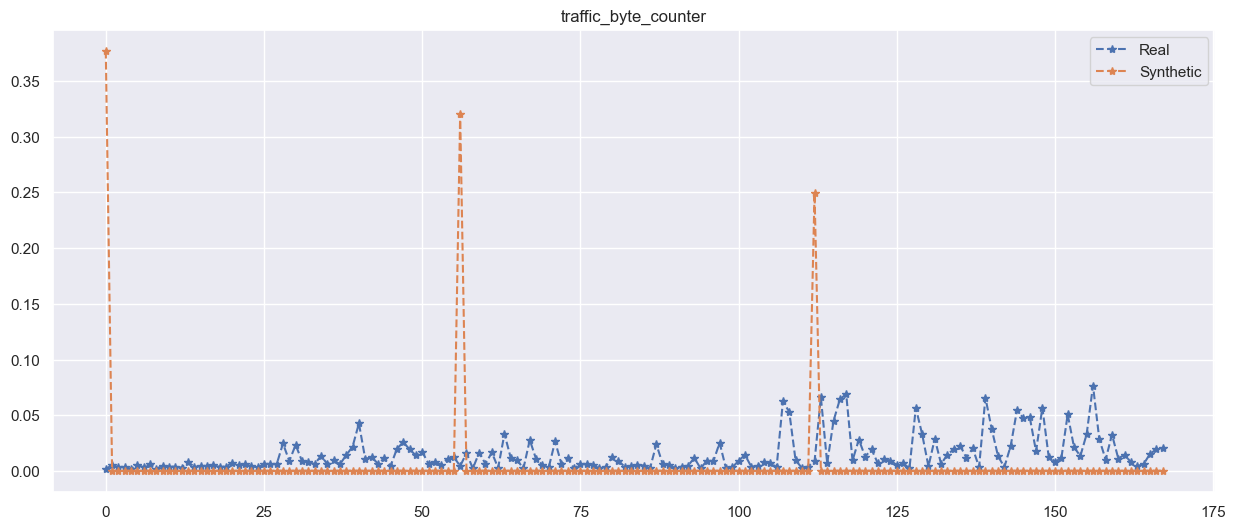

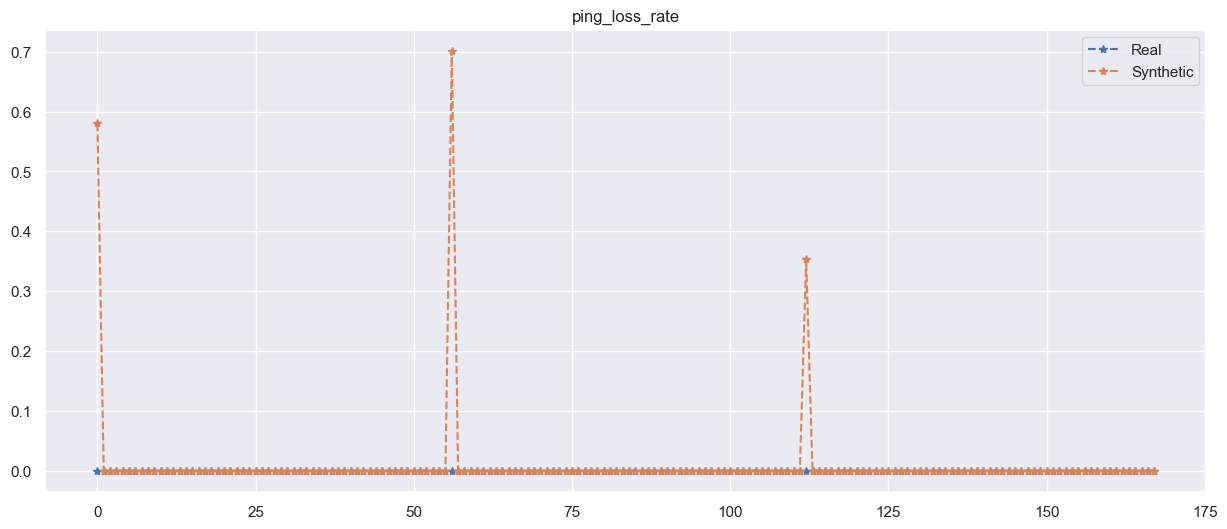

In [30]:
from paqarin.utils import plot_column_comparison
import matplotlib.pyplot as plt

figure_size: Tuple[int, int] =(15, 6)
data_points:int = sequence_length * 3

for column_name in numerical_columns:
    plot_column_comparison(real_sequence=training_dataframe.head(data_points)[column_name].reset_index(drop=True),
                           synthetic_sequence=synthetic_dataframe.head(data_points)[column_name].reset_index(drop=True),
                           column_name=column_name,
                           figure_size=figure_size)